In [1]:
import pandas as pd
from cryptocmd import CmcScraper
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from matplotlib import style, pyplot as plt
import os
from datetime import timedelta, date


tf.random.set_seed(42)
WINDOW_SIZE = 7
PRICE = 'Precio'

In [2]:
%matplotlib inline
style.use('ggplot')

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def get_crypto_df(sym):
    scraper = CmcScraper(sym)
    return scraper.get_dataframe()

In [5]:
def only_prices_df(df):
    result = df.copy()
    result.set_index('Date', inplace=True)
    return pd.DataFrame(result['Open']).rename(columns={'Open': PRICE}).astype('float32')

In [6]:
def create_windows(df, window_size):
    result = df.copy()
    for i in range(1, window_size + 1):
        result[f"Precio - {i} dia(s)"] = result[PRICE].shift(periods=i)
    return result.dropna()

In [7]:
def predict_future(model, window, days):
    future_prices = np.array([], dtype=np.float32)
    for i in range(days):
        next_day = model.predict(np.expand_dims(window, axis=0))[:, 0]
        future_prices = np.append(future_prices, next_day)
        window = np.append(next_day, window[:-1])
    start_date = date.today() + timedelta(days=1)
    dates = pd.date_range(start=start_date, periods=days)
    return pd.DataFrame({"Prices": future_prices}, index=dates)

In [8]:
df_original = get_crypto_df('BTC')[::-1]
df_original

,Date,Open,High,Low,Close,Volume,Market Cap
3402,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09
3401,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
3400,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
3399,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
3398,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
4,2022-08-17,23881.315512,24407.057907,23243.354456,23335.998222,3.093162e+10,4.462836e+11
3,2022-08-18,23341.038978,23563.831594,23177.602470,23212.739077,2.374761e+10,4.439473e+11
2,2022-08-19,23213.313242,23213.313242,20868.847439,20877.553692,4.050961e+10,3.993093e+11
1,2022-08-20,20872.842174,21350.806299,20856.731336,21166.060396,2.759567e+10,4.048481e+11


In [9]:
prices = only_prices_df(df_original)
prices = create_windows(prices, 7)
prices

,Precio,Precio - 1 dia(s),Precio - 2 dia(s),Precio - 3 dia(s),Precio - 4 dia(s),Precio - 5 dia(s),Precio - 6 dia(s),Precio - 7 dia(s)
Date,,,,,,,,
2013-05-05,112.900002,98.099998,106.250000,116.379997,139.000000,144.000000,134.444000,135.300003
2013-05-06,115.980003,112.900002,98.099998,106.250000,116.379997,139.000000,144.000000,134.444000
2013-05-07,112.250000,115.980003,112.900002,98.099998,106.250000,116.379997,139.000000,144.000000
2013-05-08,109.599998,112.250000,115.980003,112.900002,98.099998,106.250000,116.379997,139.000000
2013-05-09,113.199997,109.599998,112.250000,115.980003,112.900002,98.099998,106.250000,116.379997
...,...,...,...,...,...,...,...,...
2022-08-17,23881.316406,24126.136719,24318.316406,24429.056641,24402.187500,23957.203125,23948.345703,23162.898438
2022-08-18,23341.039062,23881.316406,24126.136719,24318.316406,24429.056641,24402.187500,23957.203125,23948.345703
2022-08-19,23213.312500,23341.039062,23881.316406,24126.136719,24318.316406,24429.056641,24402.187500,23957.203125


In [10]:
model = tf.keras.models.load_model(os.path.join('modelos', 'n-beats_final'))

In [11]:
X = prices.drop("Precio", axis=1)
X

,Precio - 1 dia(s),Precio - 2 dia(s),Precio - 3 dia(s),Precio - 4 dia(s),Precio - 5 dia(s),Precio - 6 dia(s),Precio - 7 dia(s)
Date,,,,,,,
2013-05-05,98.099998,106.250000,116.379997,139.000000,144.000000,134.444000,135.300003
2013-05-06,112.900002,98.099998,106.250000,116.379997,139.000000,144.000000,134.444000
2013-05-07,115.980003,112.900002,98.099998,106.250000,116.379997,139.000000,144.000000
2013-05-08,112.250000,115.980003,112.900002,98.099998,106.250000,116.379997,139.000000
2013-05-09,109.599998,112.250000,115.980003,112.900002,98.099998,106.250000,116.379997
...,...,...,...,...,...,...,...
2022-08-17,24126.136719,24318.316406,24429.056641,24402.187500,23957.203125,23948.345703,23162.898438
2022-08-18,23881.316406,24126.136719,24318.316406,24429.056641,24402.187500,23957.203125,23948.345703
2022-08-19,23341.039062,23881.316406,24126.136719,24318.316406,24429.056641,24402.187500,23957.203125


In [12]:
pred = model.predict(X)
pred

array([[  106.853935,   114.65698 ,   105.94866 , ...,   110.45237 ,
          112.92835 ,   113.77647 ],
       [  109.09387 ,   118.41675 ,   111.51082 , ...,   118.598885,
          116.55754 ,   116.593056],
       [  112.108   ,   103.03556 ,   109.89926 , ...,   109.29723 ,
          111.209175,   111.405655],
       ...,
       [23202.621   , 23239.361   , 23246.957   , ..., 23226.633   ,
        23239.307   , 23259.709   ],
       [20866.885   , 20894.578   , 20762.113   , ..., 20887.705   ,
        20876.012   , 20901.469   ],
       [21231.11    , 20972.65    , 21243.494   , ..., 21215.562   ,
        21235.133   , 21233.908   ]], dtype=float32)

In [13]:
y = prices["Precio"].to_numpy()

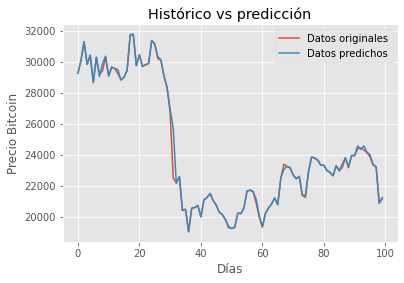

In [14]:
predicted = pred[:, 0][-100:]
original = np.array(y)[-100:]
plt.title('Histórico vs predicción')
plt.plot(original, label = 'Datos originales')
plt.plot(predicted, label = 'Datos predichos')
plt.xlabel('Días')
plt.ylabel('Precio Bitcoin')
plt.legend()
plt.show()

In [15]:
future = predict_future(model, y[-7:][::-1], 1000)
future

,Prices
2022-08-23,21241.556641
2022-08-24,20817.767578
2022-08-25,21536.550781
2022-08-26,22510.970703
2022-08-27,22109.363281
...,...
2025-05-14,198720.843750
2025-05-15,210983.000000
2025-05-16,202887.140625
2025-05-17,208438.578125


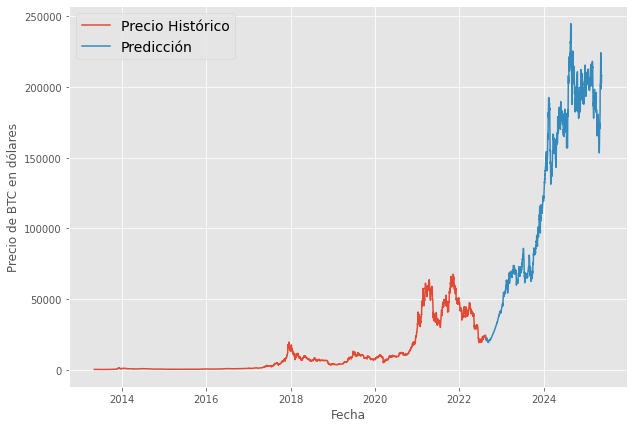

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(prices["Precio"], label="Precio Histórico")
plt.plot(future["Prices"], label="Predicción")
plt.xlabel("Fecha")
plt.ylabel("Precio de BTC en dólares")
plt.legend(fontsize=14)
plt.show();